In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, dot

In [2]:
class TF:
    def __init__(self, n, d):
        self.index = n
        self.thickness = d
        
    def matrix(self, w):
        delta = 2*pi*(self.index)*(self.thickness)/w
        ita = self.index
        element = pd.DataFrame(
            {'e1':cos(delta), 'e2':1j/ita*sin(delta), 'e3':1j*ita*sin(delta), 'e4':cos(delta)}
        )
        matrix = np.reshape(element.values.reshape(1,-1), (np.size(w), 2, 2))
        return matrix
    
def Matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def Eq_TF_Matrix(design):
    eq_matrix = design.pop()
    for i, layer in enumerate(design):
        eq_matrix = Matrix_dot(design[-i-1], eq_matrix)
    return eq_matrix

def Eq_admittance(eq, ns):
    d, _, _ = np.shape(eq)
    eq_y = dot(eq, np.array([[1], [ns]])) 
    Eq_y = pd.DataFrame(np.reshape(eq_y, (d, 2)), columns = ['B','C'])
    Y = Eq_y['C']/Eq_y['B']
    return Y.values.reshape(d, 1)
    
def Reflectance(eq, ns, n0):
    eq_Y = Eq_admittance(eq, ns)
    r = (n0-eq_Y)/(n0+eq_Y)
    R = np.reshape(r*r.conjugate(), np.size(eq_Y))
    return np.real(R)

In [29]:
def derivative(f1, f2, dx):
    return (f2 - f1)/dx

def FoM(hofx, target):
    merit = sum(abs(hofx-target))
    return merit

In [58]:
target_w = np.linspace(400, 700, 500)
substrate = 1.5 # glass 
ambient = 1 # air
### layer information
IM1 = TF(2,58).matrix(target_w)
YITO = TF(1.9, 23).matrix(target_w)
Bridge = TF(1.8, 1200).matrix(target_w)
XITO = TF(1.9, 23).matrix(target_w)
IM2 = TF(2, 58).matrix(target_w)
PL = TF(1.4, 2000).matrix(target_w)
ITO = TF(1.9, 23).matrix(target_w)

In [61]:
n_TOPIM1 = 1.41
n_TOPIM2 = 1.91
n_ITO = 1.9
d_TOPIM1 = 50
d_TOPIM2 = 10
d_ITO = 23
step = 10**(-15)
w_target = np.linspace(400, 700)
substrate = 1.5 # glass 
ambient = 1 # air

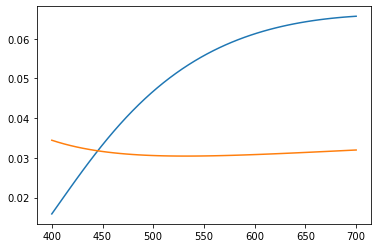

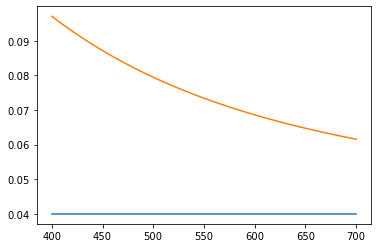

In [65]:
ITO = TF(n_ITO, d_ITO).matrix(w_target)
TOPIM1 = TF(n_TOPIM1, d_TOPIM1).matrix(w_target)
TOPIM2 = TF(n_TOPIM2, d_TOPIM2).matrix(w_target)

tf_matrix = Eq_TF_Matrix([TOPIM2, TOPIM1, ITO])
R_hofx = Reflectance(tf_matrix, substrate, ambient)

tf_matrix_target = Eq_TF_Matrix([TOPIM2, TOPIM1])
R_target = Reflectance(tf_matrix_target, substrate, ambient)

plt.plot(w_target, R_hofx, w_target, R_target)
plt.show()

tf_matrix_ITO = Eq_TF_Matrix([ITO])
R_ITO = Reflectance(tf_matrix_ITO, substrate, ambient)

R_glass = (1-1.5)**2/(1+1.5)**2*np.ones(np.size(w_target))
plt.plot(w_target, R_glass, w_target, R_ITO)
plt.show()

50
49.479594770199625
48.95685896468772
48.4322072576659
47.906048840121095
47.378796560579346
46.85087382358281
46.32271334127932
45.7945219972593
45.26646535613255
44.738709422025586
44.21142032899888
43.68476404426376
43.158906070014396
42.634011143725516
42.11024295627601
41.58776386855549
41.06673462295719
40.547314083876216
40.02965895767737
39.51392355871006
39.00025956197628
38.48881577297809
37.979737901661125
37.47316837198732
36.96924613056119
36.46810645112017
35.96988075913387
35.47469654347121
34.98267712897895
34.49394162704822
34.00860478982926
33.52677692520689
33.04856381649301
32.57406665595205
32.103381970329494
31.63660164568723
31.173812858529356
30.715098061289282
30.26053488839954
29.81019632360008
29.364150652696473
28.922461517679306
28.485187910029026
28.052384267738876
27.624100485636315
27.20038200563055
26.781269866009236
26.366800831315988
25.95700750454602
25.55191827049599
25.151557543272567
24.75594584381615
24.365099830665145
23.97903248561755
23.5977

0.034374461611676864
0.03379569393604321
0.03322667286047001
0.032667234190822896
0.032117216341325854
0.031576460850603706
0.031044811530713524
0.030522114986129556
0.03000822070530982
0.029502980332003784
0.029006247870324246
0.028517880008891865
0.028037735991171504
0.027565677151881324
0.02710156723719804
0.026645272425532503
0.026196661277467545
0.025755604174747922
0.025321973882223223
0.024895645432725984
0.024476495837108276
0.024064404178910054
0.02365925146176296
0.023260920931861967
0.02286929762641237
0.022484268578672344
0.022105722670516786
0.021733550821075403
0.021367645675768793
0.02100790158452471
0.02065421478545216
0.02030648331542591
0.01996460687708573
0.019628486960572053
0.019298026614901195
0.018973130381127253
0.018653704462215776
0.018339656782852373
0.018030896816561833
0.0177273356037494
0.01742888559239198
0.01713546057768299
0.01684697598113559
0.016563348564573206
0.016284496534618838
0.016010339515544366
0.015740798405278495
0.015475795513193653
0.01521

3.9966448014693727e-05
3.929367961259466e-05
3.863223633750955e-05
3.798192773227725e-05
3.7342565978958784e-05
3.671396680553428e-05
3.609594895197453e-05
3.548833465611899e-05
3.489094860860063e-05
3.430361871676822e-05
3.3726175612369e-05
3.315845302995711e-05
3.260028708964512e-05
3.205151692162665e-05
3.1511984442222236e-05
3.098153407095004e-05
3.046001315338763e-05
2.9947271295304597e-05
2.9443160710917335e-05
2.8947536103073754e-05
2.8460254619732547e-05
2.7981175744539607e-05
2.751016126156734e-05
2.7047075624885715e-05
2.6591785096807135e-05
2.614415872501595e-05
2.5704067300513097e-05
2.5271384050262064e-05
2.4845984394272087e-05
2.4427745661025775e-05
2.401654724708478e-05
2.3612270640804164e-05
2.3214799383341353e-05
2.282401880282435e-05
2.2439816443075452e-05
2.206208151249654e-05
2.169070508728431e-05
2.1325580186170462e-05
2.0966601365234745e-05
2.0613665325241322e-05
2.026667044738793e-05
1.9925516619755818e-05
1.9590105567312427e-05
1.926034066708147e-05
1.8936126778

4.8095598636376244e-08
4.728601925506503e-08
4.649006777256325e-08
4.5707514195069125e-08
4.493813288085512e-08
4.418170222940553e-08
4.3438004814643204e-08
4.2706825919435186e-08
4.198795469022464e-08
4.128118431466653e-08
4.058631042290649e-08
3.990313317480008e-08
3.923145548355598e-08
3.8571083948323296e-08
3.7921828321284525e-08
3.7283501107975275e-08
3.6655918810734026e-08
3.6038900596434535e-08
3.54322686961661e-08
3.4835848449642477e-08
3.4249467283796726e-08
3.367295666677371e-08
3.310615033157325e-08
3.2548884808957213e-08
3.2000999383040554e-08
3.146233649097161e-08
3.09327408347537e-08
3.041205982533432e-08
2.9900143316151625e-08
2.9396843647543332e-08
2.8902015957609192e-08
2.8415517782530683e-08
2.793720861248181e-08
2.7466950735398595e-08
2.700460834880067e-08
2.655004871442321e-08
2.610314042626902e-08
2.566375500932969e-08
2.52317654540912e-08
2.4807047371165877e-08
2.4389478636021007e-08
2.397893867843612e-08
2.357530923745463e-08
2.3178474006112477e-08
2.278831854262

6.860030253739208e-11
6.744558177393995e-11
6.631031211787925e-11
6.519404948000013e-11
6.409670504246062e-11
6.301783471605088e-11
6.195699441156106e-11
6.091409531114917e-11
5.988873773452637e-11
5.88807440460087e-11
5.788967015638632e-11
5.691516079429134e-11
5.595717155080279e-11
5.501521392778982e-11
5.408919910741047e-11
5.317850536477095e-11
5.2283177108792233e-11
5.1403169930553347e-11
5.0537995331923456e-11
4.9687209223692705e-11
4.885085601478208e-11
4.8028491615981733e-11
4.722011602729166e-11
4.642537397734399e-11
4.5643910194770834e-11
4.4875635861730226e-11
4.412019570685428e-11
4.337758973014301e-11
4.2647507069149506e-11
4.192959245250589e-11
4.1223801471291186e-11
4.0529867671979476e-11
3.984756900996584e-11
3.9176639031724366e-11
3.8517122146176036e-11
3.7868707490873956e-11
3.723126183905518e-11
3.660456314611477e-11
3.598838936744781e-11
3.5382562867370356e-11
3.4786906010198466e-11
3.4201418795932146e-11
3.362574595320351e-11
3.3059754255249604e-11
3.25033104753074

1.2894062371198821e-13
1.268089955047079e-13
1.247661851393976e-13
1.2267896585310232e-13
1.2068056440877704e-13
1.1868216296445176e-13
1.1655053475717145e-13
1.1472976899678619e-13
1.1290900323640093e-13
1.1104382855503067e-13
1.0926747171563042e-13
1.0744670595524517e-13
1.0558153127387491e-13


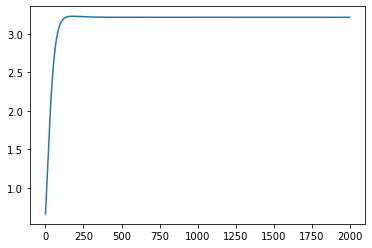

[1.0380517443447466e-13, 9.994835242489444]


In [57]:
cost = []
costi = []
d_i = []
for i in range(2000):
    alpha1 = 10**(-16)
    alpha2 = 10**(-5)
    ####
    print(d_TOPIM1)
    ITO = TF(n_ITO, d_ITO).matrix(w_target)
    TOPIM1 = TF(n_TOPIM1, d_TOPIM1).matrix(w_target)
    TOPIM2 = TF(n_TOPIM2, d_TOPIM2).matrix(w_target)
    tf_matrix = Eq_TF_Matrix([TOPIM2, TOPIM1, ITO])
    
    TOPIM1_dt = TF(n_TOPIM2, d_TOPIM1+step).matrix(w_target)
    tf_matrix_dt1 = Eq_TF_Matrix([TOPIM2, TOPIM1_dt, ITO])
    
    TOPIM2_dt = TF(n_TOPIM2, d_TOPIM2+step).matrix(w_target)
    tf_matrix_dt2 = Eq_TF_Matrix([TOPIM2_dt, TOPIM1, ITO])
    ####
    tf_matrix_target = Eq_TF_Matrix([TOPIM2, TOPIM1])
    R_target = Reflectance(tf_matrix_target, substrate, ambient)
    
    R_hofx = Reflectance(tf_matrix, substrate, ambient)
    R_hofx_dt1 = Reflectance(tf_matrix_dt1, substrate, ambient)
    R_hofx_dt2 = Reflectance(tf_matrix_dt2, substrate, ambient)
    
    J = FoM(R_hofx, R_target)
    J_dt1 = FoM(R_hofx_dt1, R_target)
    J_dt2 = FoM(R_hofx_dt2, R_target)
    ###    
    Grad_J1 = derivative(J, J_dt1, step)
    Grad_J2 = derivative(J, J_dt2, step)
    #print(J, J_dx)
    #print(Grad_J)
    #print(Grad_J)
    d_TOPIM1 = d_TOPIM1-alpha1*Grad_J1
    d_TOPIM2 = d_TOPIM2-alpha2*Grad_J2
    cost.append(J)
    costi.append(i)
    d_i.append([d_TOPIM1, d_TOPIM2])
plt.plot(costi, cost)
plt.show()
print(d_i[-1])

In [119]:
nIM1 = 1.7734
nIM2 = 2.0333

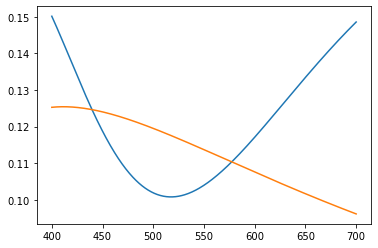

In [188]:
IM1 = TF(1.7734, 58).matrix(target_w)
IM2 = TF(2.0330, 58).matrix(target_w)
ITO = TF(1.9, 23).matrix(target_w)
tf_matrix_1 = Eq_TF_Matrix([IM2, ITO, IM1])
tf_matrix_2 = Eq_TF_Matrix([IM1])
R1 = Reflectance(tf_matrix_1, substrate, ambient)
R2 = Reflectance(tf_matrix_2, substrate, ambient)
plt.plot(w_target, R1, w_target, R2)
plt.show()

In [203]:
step = 10**(-12)
substrate = 1.5
ambient = 1

w_target = np.linspace(400, 700, 500)
IM1 = TF(1.7734, 58).matrix(w_target)
IM2 = TF(2.0330, 58).matrix(w_target)
ITO = TF(1.9, 23).matrix(w_target)
###
tf_matrix_1 = Eq_TF_Matrix([IM2, ITO, IM1])
tf_matrix_2 = Eq_TF_Matrix([IM1])
###
R1 = Reflectance(tf_matrix_1, substrate, ambient)
R2 = Reflectance(tf_matrix_2, substrate, ambient)

In [206]:
### dIM1_n
IM1_dn = TF(1.7734 + step, 58).matrix(w_target)
tf_matrix_1_dn1 = Eq_TF_Matrix([IM2, ITO, IM1_dn])
tf_matrix_2_dn1 = Eq_TF_Matrix([IM1_dn])
R1_dn1 = Reflectance(tf_matrix_1_dn1, substrate, ambient)
R2_dn1 = Reflectance(tf_matrix_2_dn1, substrate, ambient)
def delta_R(R1, R2):
    return sum(abs(R1- R2))
derivative(delta_R(R1, R2), delta_R(R1_dn1, R2_dn1), step)/5

-1.1610268302320037

In [207]:
### dIM2_n
IM2_dn = TF(2.0330 + step, 58).matrix(w_target)
tf_matrix_1_dn2 = Eq_TF_Matrix([IM2_dn, ITO, IM1])
tf_matrix_2_dn2 = Eq_TF_Matrix([IM1])
R1_dn2 = Reflectance(tf_matrix_1_dn2, substrate, ambient)
R2_dn2 = Reflectance(tf_matrix_2_dn2, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dn2, R2_dn2), step)/5

0.04050093593832571

In [208]:
### dIM1_t
IM1_dt = TF(1.7734, 58+step).matrix(w_target)
tf_matrix_1_dt1 = Eq_TF_Matrix([IM2, ITO, IM1_dt])
tf_matrix_2_dt1 = Eq_TF_Matrix([IM1_dt])
R1_dt1 = Reflectance(tf_matrix_1_dt1, substrate, ambient)
R2_dt1 = Reflectance(tf_matrix_2_dt1, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dt1, R2_dt1), step)/5

-0.06927791673660977

In [209]:
### dIM2_t
IM2_dt = TF(2.0330, 58+step).matrix(w_target)
tf_matrix_1_dt2 = Eq_TF_Matrix([IM2_dt, ITO, IM1])
tf_matrix_2_dt2 = Eq_TF_Matrix([IM1])
R1_dt2 = Reflectance(tf_matrix_1_dt2, substrate, ambient)
R2_dt2 = Reflectance(tf_matrix_2_dt2, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dt2, R2_dt2), step)/5

-0.03339550858072471

In [210]:
### dITO_n
ITO_dn = TF(1.9+ step, 23).matrix(w_target)
tf_matrix_1_dnITO = Eq_TF_Matrix([IM2, ITO_dn, IM1])
tf_matrix_2_dnITO = Eq_TF_Matrix([IM1])
R1_dnITO = Reflectance(tf_matrix_1_dnITO, substrate, ambient)
R2_dnITO = Reflectance(tf_matrix_2_dnITO, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dnITO, R2_dnITO), step)/5

2.305711177541525

In [211]:
### dITO_t
ITO_dt = TF(1.9, 23+step).matrix(w_target)
tf_matrix_1_dtITO = Eq_TF_Matrix([IM2, ITO_dt, IM1])
tf_matrix_2_dtITO = Eq_TF_Matrix([IM1])
R1_dtITO = Reflectance(tf_matrix_1_dtITO, substrate, ambient)
R2_dtITO = Reflectance(tf_matrix_2_dtITO, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dtITO, R2_dtITO), step)/5

-0.04369837824924616